In [9]:
from typing import Tuple
from torch.utils.data import Dataset
import pathlib
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd 
import numpy
import string

CANGJIE_DATASET_MEAN = 0.20013867
CANGJIE_DATASET_STD = 0.38466406

class Cangjie_Class():
    def __init__(self, file_path):
        self.class_df = []

        self.char_list = string.ascii_letters[:26]
        class_dict = {
            "id": [],
            "char": [],
            "hex": [],
            "uni": [],
            "label": [],
        }
        with open(file_path, "r") as f:
            f.readline()
            for line in f:
                id, char, hex, uni, label = line.split()
                class_dict["id"].append(int(id))
                class_dict["char"].append(char)
                class_dict["hex"].append(hex)
                class_dict["uni"].append(uni)
                class_dict["label"].append(label)

        self.class_df = pd.DataFrame(class_dict)

        self.class_df["cls"] = self.class_df.apply(lambda row: 0 if row["label"] == "zc" else 1, axis=1)

    def get_class_name_from_path(self, image_path):
        return self.class_df.iloc[int(image_path.parent.stem)]["label"]
    
    def encode_to_labels(self, txt):
        dig_lst = []
        for index, char in enumerate(txt):
            try:
                dig_lst.append(self.char_list.index(char))
            except:
                print(char)

        while len(dig_lst) < 5:
            dig_lst.append(len(self.char_list))
            
        return dig_lst
    
    def decode_to_classname(self, dig_lst):
        class_name = ''
        for dig in  dig_lst:
            try:
                class_name += self.char_list[int(dig)]
            except:
                print(dig)

        return class_name
    
    def get_classes(self):
        classes = list(self.class_df["label"])
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        idx_to_class = {i:cls_name for i, cls_name in enumerate(classes)}
        return classes, class_to_idx, idx_to_class
    
class Cangjie_Dataset(Dataset):
    
    def __init__(self, targ_dir: str, set:str, transform=None) -> None:
        self.cangjie = Cangjie_Class(pathlib.Path(targ_dir) / "952_labels.txt")
        self.paths = list((pathlib.Path(targ_dir)/ f"952_{set}").glob("*/*.png"))
        self.transform = transform
        self.classes, self.class_to_idx, self.idx_to_class = self.cangjie.get_classes()

    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.cangjie.get_class_name_from_path(self.paths[index])
        class_label = self.cangjie.encode_to_labels(class_name)
        class_label = torch.Tensor(class_label)
        if self.transform:
            return self.transform(img), class_label
        else:
            return img, class_label

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

train_data = Cangjie_Dataset("etl_952_singlechar_size_64", "train", transform=train_transforms)

class_names = train_data.classes
class_dict = train_data.class_to_idx

In [12]:
train_data[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([25.,  2., 26., 26., 26.]))

In [1]:
from cangjie_dataset import get_cangjie_val_dataloader

dataset = get_cangjie_val_dataloader()

for (images, labels) in dataset:
    print(labels.shape)

torch.Size([16, 5])
torch.Size([16, 5])
torch.Size([16, 5])
torch.Size([16, 5])
torch.Size([16, 5])
torch.Size([16, 5])
torch.Size([16, 5])
torch.Size([16, 5])


KeyboardInterrupt: 

TypeError: 'DataLoader' object does not support indexing

In [88]:
image, label = train_data[0]

torch.Tensor(label).tolist()

train_data.cangjie.decode_to_classname(torch.Tensor(label).tolist())

'zc'

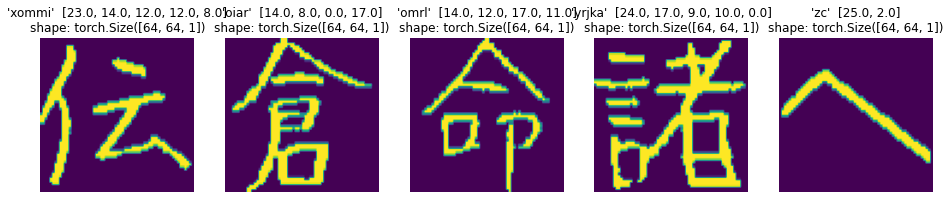

In [90]:
from typing import List
import matplotlib.pyplot as plt
import random
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"'{dataset.cangjie.decode_to_classname(targ_label.tolist())}'  {targ_label.tolist()}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


display_random_images(train_data, 
                      n=5, 
                      classes=class_names,)

In [ ]:
import editdistance
editdistance.eval('banana', 'bahama')

In [28]:
import torch
from torch import nn

# target output size of 5x7
max_length = 5
nb_classes = 3
input = torch.randn(1, 512, 113, 113)
conv2d = nn.Conv2d(512, max_length, 1)
# m = nn.AdaptiveAvgPool2d(1)
m = nn.AdaptiveAvgPool2d((1, nb_classes))

cn = conv2d(input)
output = m(cn)
output = m(cn).view(-1, max_length, nb_classes)

print(input.shape)
print(cn.shape)
print(output.shape)

torch.Size([1, 512, 113, 113])
torch.Size([1, 5, 113, 113])
torch.Size([1, 5, 3])


In [33]:
output = torch.Tensor([[
    [1,0,0],
    [0,2,0],
    [3,0,0],
    [4,0,0],
    [5,0,0],
]])

print(output)
print(output.shape)

tensor([[[1., 0., 0.],
         [0., 2., 0.],
         [3., 0., 0.],
         [4., 0., 0.],
         [5., 0., 0.]]])
torch.Size([1, 5, 3])


In [36]:
output = output.permute(1, 0, 2)
print(output)
print(output.shape)

tensor([[[1., 0., 0.]],

        [[0., 2., 0.]],

        [[3., 0., 0.]],

        [[4., 0., 0.]],

        [[5., 0., 0.]]])
torch.Size([5, 1, 3])


In [14]:
t = torch.rand(4, 4)
print(t)
b = t.view(2, 8)
print(b)

tensor([[0.2566, 0.7060, 0.0869, 0.4771],
        [0.0953, 0.6888, 0.3911, 0.3436],
        [0.7084, 0.2926, 0.3557, 0.0896],
        [0.4327, 0.5600, 0.9033, 0.7683]])
tensor([[0.2566, 0.7060, 0.0869, 0.4771, 0.0953, 0.6888, 0.3911, 0.3436],
        [0.7084, 0.2926, 0.3557, 0.0896, 0.4327, 0.5600, 0.9033, 0.7683]])


In [60]:
import torch.nn as nn

# Target are to be padded
T = 5      # Input sequence length
C = 26      # Number of classes (including blank)
N = 3      # Batch size
S = 5      # Target sequence length of longest target in batch (padding length)
S_min = 1  # Minimum target length, for demonstration purposes
# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
# Initialize random batch of targets (0 = blank, 1:C = classes)
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
# loss.backward()

print(input_lengths, target_lengths)
print(input.shape)
print(target.shape)
print(loss)


tensor([5, 5, 5]) tensor([1, 2, 4])
torch.Size([5, 3, 26])
torch.Size([3, 5])
tensor(9.4594, grad_fn=<MeanBackward0>)


In [2]:
from cangjie_dataset import get_cangjie_training_dataloader, get_cangjie_val_dataloader
import logging 

logging.basicConfig(
    level=logging.INFO,  # Set the root logger level (DEBUG logs everything)
    # format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', 
    handlers=[
        # logging.FileHandler("my_app.log"),  # Log to a file
        logging.StreamHandler()             # Log to console 
    ]
)

log = logging.getLogger("hehe")

cangjie_training_loader = get_cangjie_training_dataloader()
cangjie_val_loader = get_cangjie_val_dataloader()

In [3]:
from models.squeezenet_cangjie import squeezenet
import torch
from torch import nn

ouputs = None
ground_truths = None

def train(epoch = 0):
    global outputs
    global ground_truths
    
    net.train()
    for batch_index, (images, labels) in enumerate(cangjie_training_loader):
        ground_truths = labels
 

        outputs = net(images)

        # log.info(f'labels.shape: {labels.shape}')
        # log.info(f'outputs.shape: {outputs.shape}')

        loss = calculate_loss(outputs, labels)

        break
        
def calculate_loss(predict, ground_truth):
    '''
    T = 50      # Input sequence length
    C = 20      # Number of classes (including blank)
    N = 16      # Batch size
    S = 30      # Target sequence length of longest target in batch 
    Args:
        - inputs: (T,N,C) (5, batch_size, 26)
    '''
    T = 5
    N = ground_truth.shape[0]
    log.info(f"ground_truth: {ground_truth}")
    log.info(f"predict: {predict}")
    predict = predict.permute(1, 0, 2) #.contiguous()
    log.info(f"predict shape: {predict.shape}")
    log.info(f"ground_truth shape: {ground_truth.shape}")
    input_lengths = target_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
    log.info(f"input_lengths: {input_lengths}")
    log.info(f"input_lengths shape: {input_lengths.shape}")
    log.info(f"target_lengths: {target_lengths}")
    log.info(f"target_lengths shape: {target_lengths.shape}")
    loss = ctc_loss(predict, ground_truth, input_lengths, target_lengths)
    log.info(f"loss: {loss.item()}")
    return loss

net = squeezenet()

ctc_loss = nn.CTCLoss(27)

net

# train()

INFO:models.squeezenet_cangjie:28


SqueezeNet(
  (stem): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fire2): Fire(
    (squeeze): Sequential(
      (0): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (expand_1x1): Sequential(
      (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (expand_3x3): Sequential(
      (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )

In [4]:
def calculate_loss(predict, ground_truth):
    T = ground_truth.shape[1]
    N = ground_truth.shape[0]

    target = ground_truth.type(torch.LongTensor)
    inputs = predict.log_softmax(2)

    target_lengths = []

    for img in ground_truth.tolist():
        i = 0
        while i < 5 and img[i] < 26.0:
            i += 1
        target_lengths.append(i)
    target_lengths = torch.Tensor(target_lengths).type(torch.LongTensor)

    inputs = inputs.permute(1, 0, 2) #.contiguous()
    input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
    loss = ctc_loss(inputs, target, input_lengths, target_lengths)
    log.info(f"loss: {loss.item()}")
    return loss

In [12]:
from cangjie_dataset import Cangjie_Class

@torch.no_grad()
def eval_training(epoch=0, tb=True):
    net.eval()

    test_loss = 0.0 # cost function error
    correct = 0.0

    frac = 0
    for (images, labels) in cangjie_val_loader:

        outputs = net(images)
        loss = calculate_loss(outputs, labels)

        test_loss += loss.item()
        _, preds = outputs.max(2)
        
        preds = preds.tolist()
        labels = labels.tolist()
        for i in range(labels.shape[0]):
            preds_str = cangjie_class.decode_to_classname(preds[i])
            labels_str = cangjie_class.decode_to_classname(labels[i])
            frac += editdistance.eval(preds_str, labels_str)
            deno += 1 if labels_str == "zc" else len(labels_str)
        print(outputs.shape)
        print(preds.shape)
        print(labels.shape)
        # correct += preds.eq(labels).sum()

        break

    # return correct.float() / len(cangjie_val_loader.dataset)

cangjie_class = Cangjie_Class("etl_952_singlechar_size_64/952_labels.txt")
eval_training()

INFO:hehe:loss: 7.529937744140625


torch.Size([16, 10, 28])
torch.Size([16, 10])
torch.Size([16, 10])


In [62]:
import torch.nn as nn

# Target are to be padded
T = 5      # Input sequence length
C = 28      # Number of classes (including blank)
N = 16      # Batch size
S = 5      # Target sequence length of longest target in batch (padding length)
S_min = 1  # Minimum target length, for demonstration purposes
# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
# Initialize random batch of targets (0 = blank, 1:C = classes)
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
ctc_loss = nn.CTCLoss(27)
loss = ctc_loss(input, target, input_lengths, target_lengths)
# loss.backward()

print(input_lengths, target_lengths)
print(input.shape)
print(target.shape)
print(loss)

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]) tensor([4, 3, 2, 1, 4, 2, 1, 2, 2, 2, 2, 3, 2, 3, 2, 2])
torch.Size([5, 16, 28])
torch.Size([16, 5])
tensor(7.3858, grad_fn=<MeanBackward0>)


In [19]:
input.shape

torch.Size([5, 16, 28])

In [30]:
import torch
from torch import nn

target = ground_truths.type(torch.LongTensor)
inputs = outputs.requires_grad_()

target_lengths = []

for img in ground_truths.tolist():
    i = 0
    while i < 5 and img[i] < 26.0:
        i += 1
    target_lengths.append(i)
target_lengths = torch.Tensor(target_lengths).type(torch.LongTensor)

T = 5
N = target.shape[0]
inputs = inputs.permute(1, 0, 2) #.contiguous()
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
ctc_loss = nn.CTCLoss(27)
loss = ctc_loss(inputs, target, input_lengths, target_lengths)

print(input_lengths, target_lengths)
print(inputs.shape)
print(target.shape)
print(loss)

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]) tensor([5, 2, 2, 4, 2, 5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4])
torch.Size([5, 16, 28])
torch.Size([16, 5])
tensor(inf, grad_fn=<MeanBackward0>)


In [8]:
print(target.shape)
print(inputs.shape)

torch.Size([16, 5])
torch.Size([5, 16, 28])


In [17]:
target

tensor([[23, 24, 17,  2, 17],
        [ 9, 21, 26, 26, 26],
        [10, 13, 26, 26, 26],
        [ 8,  4, 14, 10, 26],
        [25,  2, 26, 26, 26],
        [12, 14,  1, 20,  2],
        [24,  1, 14, 10, 26],
        [23, 22,  6,  5, 26],
        [24, 17,  5,  5, 26],
        [14,  8,  7,  4, 26],
        [24,  8,  9,  2, 26],
        [22, 11, 11, 12, 24],
        [24, 19,  0,  9, 26],
        [17, 18, 11, 13, 26],
        [12,  9, 11, 13, 26],
        [ 5, 21, 14, 10, 26]])

In [12]:
target_lengths

tensor([5, 2, 2, 4, 2, 5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4])